Este no lo he estudiado, idk de donde salió pero lo dejaré para tener modelos de prueba por el momento.

In [1]:
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import joblib

In [2]:
def agregar_lags(df, columna, lags):
    """Agrega variables de retardo (lags) al DataFrame."""
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    """Agrega variables de medias móviles al DataFrame."""
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    """Agrega variables cíclicas seno/coseno para mes y día de la semana."""
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    """Agrega variables de Media Móvil Exponencial (EWMA) al DataFrame."""
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def obtener_semestre(mes):
    """Define la variable Semestre (1, 2 o 0)."""
    if 3 <= mes <= 7:
        return 1
    elif 8 <= mes <= 12:
        return 2
    else:
        return 0

In [3]:
try:
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'daily_counts_full.csv'.")
    exit(1)

for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)
daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 
].reset_index(drop=True)

daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)

def semana_en_semestre(row):
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [4]:
daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

FEATURES = ['Semana_Certamen', 'media_movil_7', 'media_movil_14', 'media_movil_30',
            'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
            'lag_7', 'lag_14', 'lag_21', 'ewma_7', 'ewma_14', 'ewma_30']
TARGET = 'Accesos'

X = daily_counts_full[FEATURES]
y = daily_counts_full[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train_aug = [X_train.copy()]
y_train_aug = [y_train.copy()]
N_AUGMENTATIONS = 4

for i in range(N_AUGMENTATIONS):
    if i % 2 == 0:
        y_new = y_train * np.random.uniform(0.95, 1.05, len(y_train))
    else:
        y_new = y_train + np.random.normal(0, y_train.std() * 0.02, len(y_train))
    
    df_new = X_train.copy()
    df_new['Accesos'] = y_new

    df_new = df_new.drop(columns=[col for col in df_new.columns if 'media_movil' in col or 'ewma' in col or 'lag_' in col], errors='ignore')
    df_new = agregar_medias_moviles(df_new, 'Accesos', [7, 14, 30])
    df_new = agregar_ewma(df_new, 'Accesos', [7, 14, 30])
    df_new = agregar_lags(df_new, 'Accesos', [7, 14, 21])

    df_new = df_new.dropna().reset_index(drop=True)
    
    X_train_aug.append(df_new[FEATURES])
    y_train_aug.append(df_new['Accesos'])

X_train_final = pd.concat(X_train_aug)
y_train_final = pd.concat(y_train_aug)

print(f"\n")
print(f"Preparación de Datos Finalizada")
print(f"Datos de entrenamiento: {len(y_train)} | Datos de prueba: {len(y_test)}")
print(f"Número de Features Exógenas: {len(FEATURES)}")



Preparación de Datos Finalizada
Datos de entrenamiento: 256 | Datos de prueba: 64
Número de Features Exógenas: 14


In [5]:
# Entrenamiento y Evaluación con CatBoost

tscv = TimeSeriesSplit(n_splits=5)

# Parámetros ajustados para CatBoost (usando un grid reducido para eficiencia)
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.05, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3], # Regularización L2
    'border_count': [128] # Cantidad de buckets para codificación de features numéricas
}

print("Iniciando entrenamiento y ajuste de hiperparámetros de CatBoost...")

# 1. Búsqueda de Hyperparámetros
# Usamos un CatBoostRegressor con parámetros base de silencio (verbose=0)
grid_search = GridSearchCV(
    CatBoostRegressor(random_state=42, thread_count=-1, verbose=0, loss_function='RMSE'),
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_final, y_train_final)

print(f'Mejores parámetros para CatBoost: {grid_search.best_params_}')

# 2. Entrenamiento del modelo final con los mejores parámetros
best_params = grid_search.best_params_
model = CatBoostRegressor(**best_params, random_state=42, thread_count=-1, verbose=0, loss_function='RMSE')
model.fit(X_train_final, y_train_final)

# Guardar el modelo
os.makedirs(os.path.dirname('Archivos Auxiliares/'), exist_ok=True)
joblib.dump(model, 'Archivos Auxiliares/modelo_CatBoost.pkl')
print("Modelo CatBoost guardado como 'Archivos Auxiliares/modelo_CatBoost.pkl'")


Iniciando entrenamiento y ajuste de hiperparámetros de CatBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag

Mejores parámetros para CatBoost: {'border_count': 128, 'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Modelo CatBoost guardado como 'Archivos Auxiliares/modelo_CatBoost.pkl'



--- Evaluación de rendimiento de CatBoost en el set de prueba ---
R²: 0.51
Error Cuadrático Medio (MSE): 1073745.78
Error Cuadrático Medio Raíz (RMSE): 1036.22
Error Absoluto Medio (MAE): 740.40

Se han generado las siguientes visualizaciones:
- catboost_predicciones.png (Comparación de valores reales vs. predichos)
- catboost_importancia.png (Importancia de las variables)


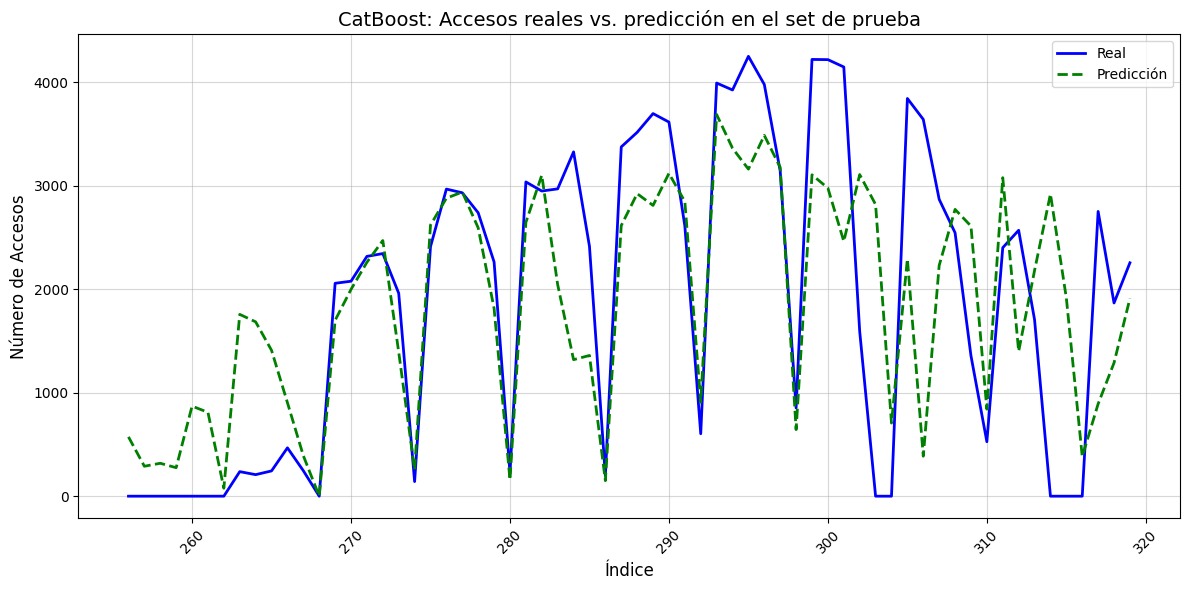

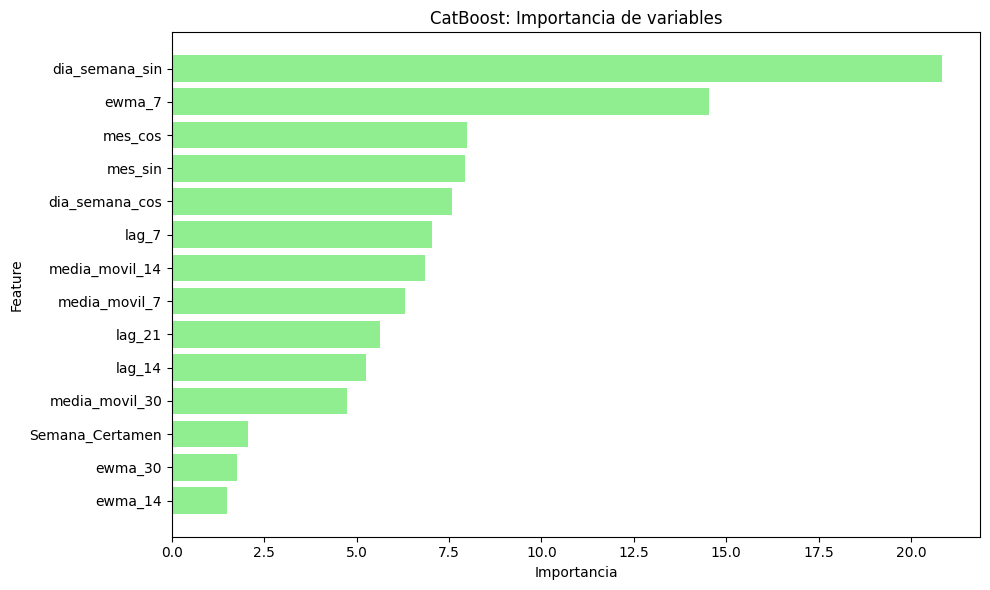

In [6]:
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

# Cálculo de métricas
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print("\n--- Evaluación de rendimiento de CatBoost en el set de prueba ---")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

# Graficar resultados de la predicción (Real vs. Predicción en el test set)
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
plt.title('CatBoost: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('catboost_predicciones.png')


# Graficar importancia de variables
importances = model.get_feature_importance()
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='lightgreen')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("CatBoost: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('catboost_importancia.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- catboost_predicciones.png (Comparación de valores reales vs. predichos)")
print("- catboost_importancia.png (Importancia de las variables)")